In [2]:
import os, torch
from xml.etree import ElementTree as ET
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split



In [3]:
FOLDER_DATASET = "/mnt/linux/stallionSpace/itu/semester3/thesis1/datasets/VMMRdb"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_CLASSES = None
EPOCHS = 15

In [4]:
print(DEVICE)

cpu


# Definations

In [17]:

class CustomDataset(Dataset):
    def __init__(self,X,y,all_classes, root_dir, transform=None ) -> None:
        self.X = X
        self.y = y
        self.root_dir = root_dir
        assert len(self.X) == len(self.y)

        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(set(all_classes))}
        for i,label in enumerate(self.label_map.keys()):
          self.label_map[label] = i


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        img_name = self.X[idx]
        label = self.y[idx]
        img_path = os.path.join(self.root_dir, label, img_name)

        label_arr = label.split('_')
        label = "_".join(label_arr[:-2])

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        label = torch.tensor(self.label_map[label], dtype=torch.long)
        return image, label

In [6]:
def test_accuracy(model, test_loader):
  with torch.no_grad():
      total_correct = 0
      total_samples = 0
      for images, labels in test_loader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total_correct += (predicted == labels).sum().item()
          total_samples += labels.size(0)

      accuracy = total_correct / total_samples
      print(f'Test Accuracy On best Model: {accuracy:.4f}')

In [7]:
import copy
def train(epochs, model, criterion, optimizer, train_loader, valid_loader, test_loader):
  best_model = None
  best_acc = 0

  # Training loop
  for epoch in range(epochs):
      model.train()
      total_train_correct = 0
      total_train_samples = 0
      for images, labels in train_loader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          _, predicted = torch.max(outputs, 1)
          total_train_correct += (predicted == labels).sum().item()
          total_train_samples += labels.size(0)
      train_accuracy = total_train_correct / total_train_samples

      # Validation loop
      model.eval()
      with torch.no_grad():
          total_correct = 0
          total_samples = 0
          for images, labels in valid_loader:
              images, labels = images.to(DEVICE), labels.to(DEVICE)
              outputs = model(images)
              _, predicted = torch.max(outputs, 1)
              total_correct += (predicted == labels).sum().item()
              total_samples += labels.size(0)

          accuracy = total_correct / total_samples
          print(f'Epoch [{epoch+1}/{epochs}], Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {accuracy:.4f}')

          if (accuracy > best_acc):
            print("New Best Model with Accuracy: ", accuracy)
            best_acc = accuracy
            best_model = copy.deepcopy(model)

  print("Training finished.")

  # Testing the model
  model.eval()
  with torch.no_grad():
      total_correct = 0
      total_samples = 0
      for images, labels in test_loader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = best_model(images)
          _, predicted = torch.max(outputs, 1)
          total_correct += (predicted == labels).sum().item()
          total_samples += labels.size(0)

      accuracy = total_correct / total_samples
      print(f'Test Accuracy On best Model: {accuracy:.4f}')
  return best_model

In [40]:
class CenterCropPercentage(object):
    """
    Crop the center region of an image by a percentage.
    
    Args:
    - crop_percent: Percentage to crop from the center.
    """
    def __init__(self, crop_percent):
        self.crop_percent = 1-crop_percent

    def __call__(self, img):
        width, height = img.size

        crop_width_size = width * self.crop_percent
        crop_height_size = height * self.crop_percent

        # Calculate the crop box
        left = (width - crop_width_size) / 2
        upper = (height - crop_height_size) / 2
        right = (width + crop_width_size) / 2
        lower = (height + crop_height_size) / 2

        # Perform the crop
        return img.crop((left, upper, right, lower))

        crop_width = int(width * self.crop_percent)
        crop_height = int(height * self.crop_percent)

        # Calculate the size for center cropping
        crop_size = min(width, height, crop_width, crop_height)

        # Center crop the image
        center_crop = transforms.CenterCrop(crop_size)
        return center_crop(img)

# Dataset Preparation

In [9]:
classes_list = os.listdir(FOLDER_DATASET)
dataset_list = []

for _class in classes_list:
  images = os.listdir(os.path.join(FOLDER_DATASET,_class))
  for image in images:
    class_l =  _class.split("_")
    dataset_list.append((image,_class,"_".join(class_l[:-2])))
dataset_list = np.array(dataset_list)
NUM_CLASSES = len(np.unique(dataset_list[:,2]))

print("Dataset Images:",len(dataset_list), "TOTAL CLASSES: ", NUM_CLASSES)

Dataset Images: 285086 TOTAL CLASSES:  145


In [62]:
X_train, X_test, y_train, y_test = train_test_split(dataset_list[:,0],dataset_list[:,1], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


transform = transforms.Compose([
    CenterCropPercentage(0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(X_train,y_train,dataset_list[:,2],FOLDER_DATASET, transform)
valid_dataset = CustomDataset(X_val, y_val,dataset_list[:,2], FOLDER_DATASET, transform)
test_dataset = CustomDataset(X_test,y_test,dataset_list[:,2], FOLDER_DATASET, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Main

In [55]:

transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # CenterCropPercentage(0.2),
    # transforms.ToTensor(),
])

train_dataset_t = CustomDataset(X_train,y_train,dataset_list[:,2],FOLDER_DATASET, transform)


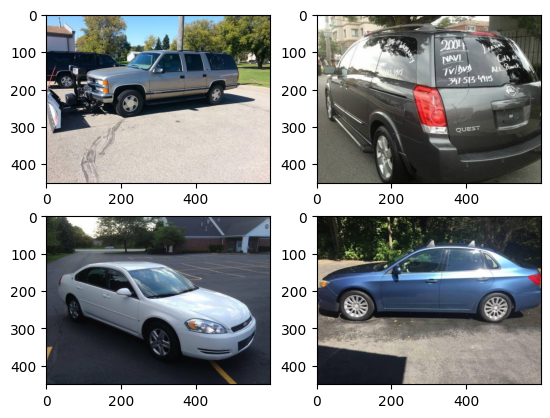

In [61]:
plt.subplot(221)
plt.imshow(train_dataset_t[0][0])

plt.subplot(222)
plt.imshow(train_dataset_t[1][0])

plt.subplot(223)
plt.imshow(train_dataset_t[2][0])


plt.subplot(224)
plt.imshow(train_dataset_t[3][0])

In [10]:
model = models.densenet121(weights=None, num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model = train(EPOCHS,model,criterion,optimizer,train_loader,valid_loader,test_loader)

Epoch [1/15], Training Accuracy: 0.0744, Validation Accuracy: 0.1477
New Best Model with Accuracy:  0.14772787063507375
Epoch [2/15], Training Accuracy: 0.3279, Validation Accuracy: 0.4368
New Best Model with Accuracy:  0.43681708963993193
Epoch [3/15], Training Accuracy: 0.5245, Validation Accuracy: 0.5331
New Best Model with Accuracy:  0.5331041619166214


In [ ]:
torch.save(best_model,"vmmrdb_pretraining.pt")